# Control Strategies for Dynamic Systems

This notebook provides implementation examples of various control methods used in dynamic systems, ranging from classical control to advanced nonlinear and adaptive techniques.

**Author:** Carlos Andrés Sierra, M.Sc.

**Course:** Systems Sciences Foundations

**Universidad Distrital Francisco José de Caldas**

## Table of Contents

1. [Setup and Requirements](#setup)
2. [Classical Control Techniques](#classical)
   - [PID Control](#pid)
   - [Root Locus](#root-locus)
   - [Frequency Response](#frequency)
3. [Modern Control Theory](#modern)
   - [State Feedback Control](#state-feedback)
   - [Optimal Control (LQR)](#optimal)
   - [Observer Design](#observer)
   - [Robust Control](#robust)
4. [Adaptive Control](#adaptive)
   - [Model Reference Adaptive Control](#mrac)
   - [Self-Tuning Regulators](#str)
   - [Gain Scheduling](#gain)
5. [Nonlinear Control](#nonlinear)
   - [Feedback Linearization](#feedback-lin)
   - [Backstepping](#backstepping)
   - [Sliding Mode Control](#sliding)
   - [Passivity-Based Control](#passivity)

<a id="setup"></a>
## Setup and Requirements

Let's first install and import the necessary libraries for control systems simulation and analysis:

In [1]:
# Install necessary packages if not already installed
!pip install numpy scipy matplotlib control


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
from scipy.integrate import solve_ivp
import control

# Set up plotting
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = [12, 8]

<a id="classical"></a>
## Classical Control Techniques

Classical control theory focuses on single-input, single-output (SISO) systems and provides fundamental tools for analysis and design of feedback control systems.

<a id="pid"></a>
### PID Control

PID (Proportional-Integral-Derivative) control is one of the most common control algorithms. It adjusts the control input based on:
- **P (Proportional)**: Proportional to the current error
- **I (Integral)**: Accumulates past errors
- **D (Derivative)**: Anticipates future errors by considering the rate of change

The control law is defined as:

$$u(t) = K_p e(t) + K_i \int_0^t e(\tau) d\tau + K_d \frac{de(t)}{dt}$$

where:
- $u(t)$ is the control signal
- $e(t) = r(t) - y(t)$ is the error (setpoint minus measured output)
- $K_p$, $K_i$, and $K_d$ are the proportional, integral, and derivative gains

Let's implement a PID controller for a simple system:

In [3]:
class PIDController:
    def __init__(self, Kp=1.0, Ki=0.0, Kd=0.0, setpoint=0):
        """Initialize PID controller with gain parameters and setpoint"""
        self.Kp = Kp  # Proportional gain
        self.Ki = Ki  # Integral gain
        self.Kd = Kd  # Derivative gain
        self.setpoint = setpoint  # Desired output value
        self.reset()
        
    def reset(self):
        """Reset controller states"""
        self.previous_error = 0
        self.integral = 0
        
    def update(self, measurement, dt):
        """Update controller based on new measurement and time step"""
        # Calculate error
        error = self.setpoint - measurement
        
        # Proportional term
        P = self.Kp * error
        
        # Integral term
        self.integral += error * dt
        I = self.Ki * self.integral
        
        # Derivative term
        derivative = (error - self.previous_error) / dt
        D = self.Kd * derivative
        
        # Store error for next iteration
        self.previous_error = error
        
        # Calculate total control signal
        control_signal = P + I + D
        
        return control_signal

Let's test our PID controller with a simple first-order system:

$$\frac{dy(t)}{dt} = -a \cdot y(t) + b \cdot u(t)$$

where:
- $y(t)$ is the system output
- $u(t)$ is the control input
- $a$ and $b$ are system parameters

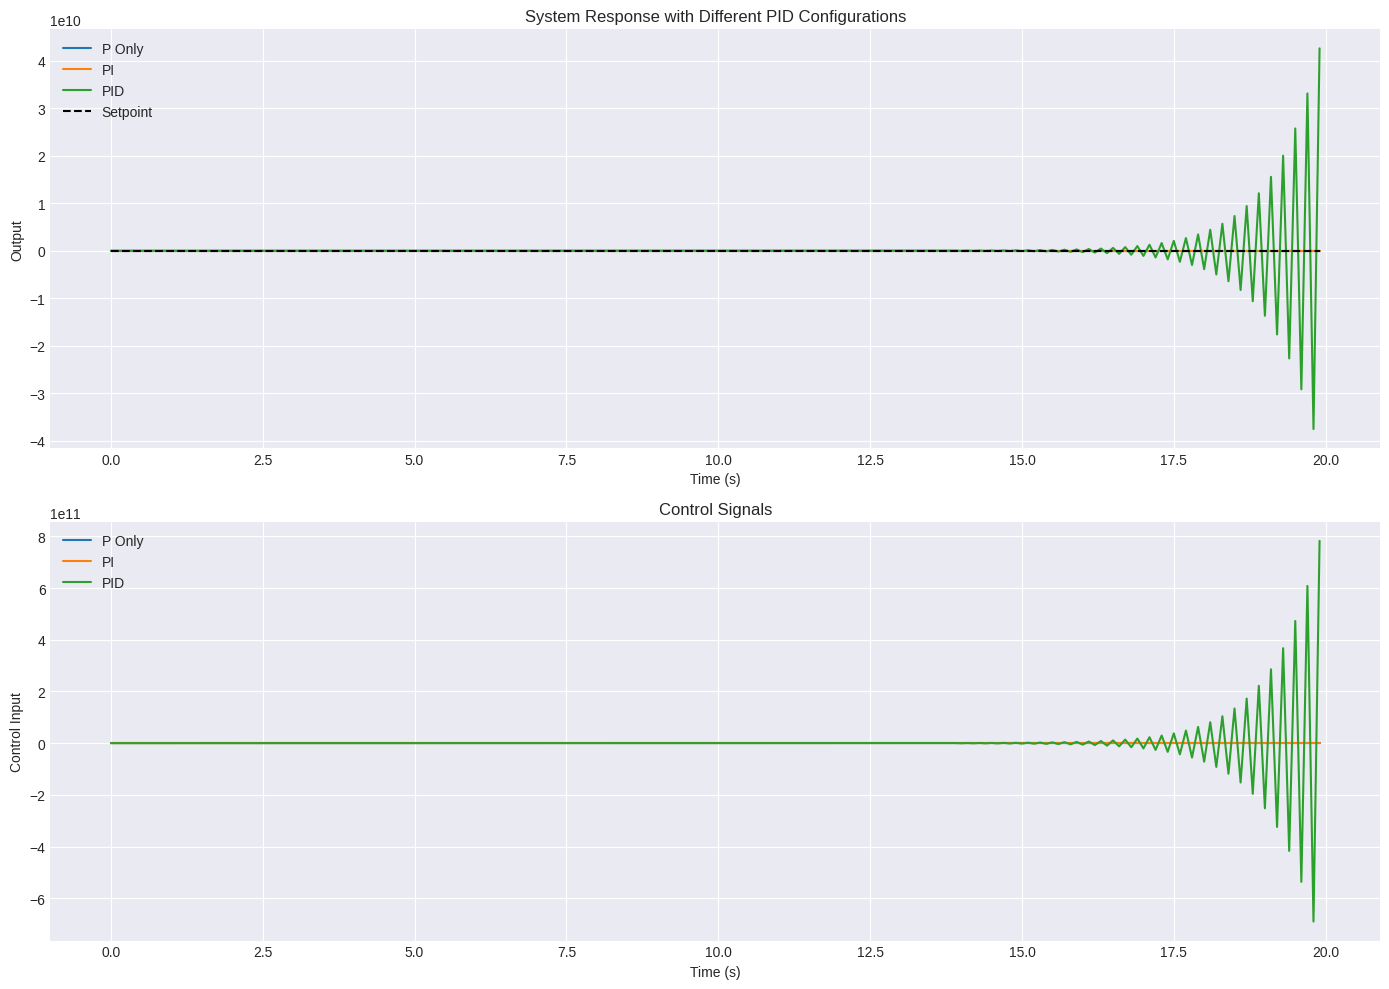

In [4]:
def first_order_system(t, y, u, a=1.0, b=1.0):
    """First-order differential equation: dy/dt = -a*y + b*u"""
    return -a * y + b * u

# Simulation parameters
t_start = 0.0
t_end = 20.0
dt = 0.1
t = np.arange(t_start, t_end, dt)
n_steps = len(t)

# System parameters
a = 0.5  # System decay rate
b = 1.0  # Input gain

# Create arrays to store results
y = np.zeros(n_steps)
u = np.zeros(n_steps)
setpoint = np.ones(n_steps)  # Step input
setpoint[:20] = 0  # Start with zero setpoint for 2 seconds

# Set initial conditions
y[0] = 0.0

# Create PID controller with different gain configurations
controllers = [
    {"name": "P Only", "gains": (2.0, 0.0, 0.0)},
    {"name": "PI", "gains": (2.0, 0.5, 0.0)},
    {"name": "PID", "gains": (2.0, 0.5, 1.0)}
]

plt.figure(figsize=(14, 10))

for i, controller_config in enumerate(controllers):
    # Reset arrays for each controller
    y = np.zeros(n_steps)
    u = np.zeros(n_steps)
    
    # Create controller with specified gains
    Kp, Ki, Kd = controller_config["gains"]
    pid = PIDController(Kp=Kp, Ki=Ki, Kd=Kd, setpoint=1.0)
    
    # Simulate system with this PID configuration
    for j in range(1, n_steps):
        # Update PID controller
        u[j] = pid.update(y[j-1], dt)
        
        # Update system state using simple Euler integration
        dydt = first_order_system(t[j], y[j-1], u[j], a, b)
        y[j] = y[j-1] + dydt * dt
    
    # Plot results
    plt.subplot(2, 1, 1)
    plt.plot(t, y, label=f'{controller_config["name"]}')
    
    plt.subplot(2, 1, 2)
    plt.plot(t, u, label=f'{controller_config["name"]}')

# Finalize the plots
plt.subplot(2, 1, 1)
plt.plot(t, setpoint, 'k--', label='Setpoint')
plt.grid(True)
plt.xlabel('Time (s)')
plt.ylabel('Output')
plt.title('System Response with Different PID Configurations')
plt.legend()

plt.subplot(2, 1, 2)
plt.grid(True)
plt.xlabel('Time (s)')
plt.ylabel('Control Input')
plt.title('Control Signals')
plt.legend()

plt.tight_layout()
plt.show()

**Explanation of PID Control Results**:

- **P Controller**: Responds proportionally to the error. It can lead to steady-state errors and may not reach the setpoint exactly.

- **PI Controller**: The integral term accumulates past errors to eliminate steady-state error. However, it can increase overshoot and settling time.

- **PID Controller**: The derivative term anticipates future errors by considering the rate of change, which helps reduce overshoot and improve transient response.

In practice, PID tuning is critical for optimal performance, and methods like Ziegler-Nichols, Cohen-Coon, or manual tuning are commonly used.

<a id="root-locus"></a>
### Root Locus Analysis

Root locus is a graphical method that shows how the poles of a closed-loop system change as a function of a parameter (typically the gain). It provides insights into stability and transient response characteristics.

Let's explore root locus analysis for a second-order system:

In [5]:
# Define a second-order system transfer function
# G(s) = b / (s^2 + a*s + c)
a = 2.0  # damping coefficient
b = 10.0  # gain
c = 5.0  # spring constant

num = [b]  # numerator coefficients
den = [1, a, c]  # denominator coefficients

# Create transfer function using scipy.signal
sys_scipy = signal.TransferFunction(num, den)

# Create transfer function using control module
sys_control = control.TransferFunction(num, den)

# Print the transfer function details
print(f"Transfer function G(s) = {b} / (s^2 + {a}s + {c})")
print(f"Open-loop poles: {signal.tf2zpk(num, den)[1]}")

Transfer function G(s) = 10.0 / (s^2 + 2.0s + 5.0)
Open-loop poles: [-1.+2.j -1.-2.j]


/home/casierrav/.pyenv/versions/3.12.7/envs/test/lib/python3.12/site-packages/control/rlocus.py:210: FutureWarning: root_locus() return value of roots, gains is deprecated; use root_locus_map()
  warnings.warn(
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


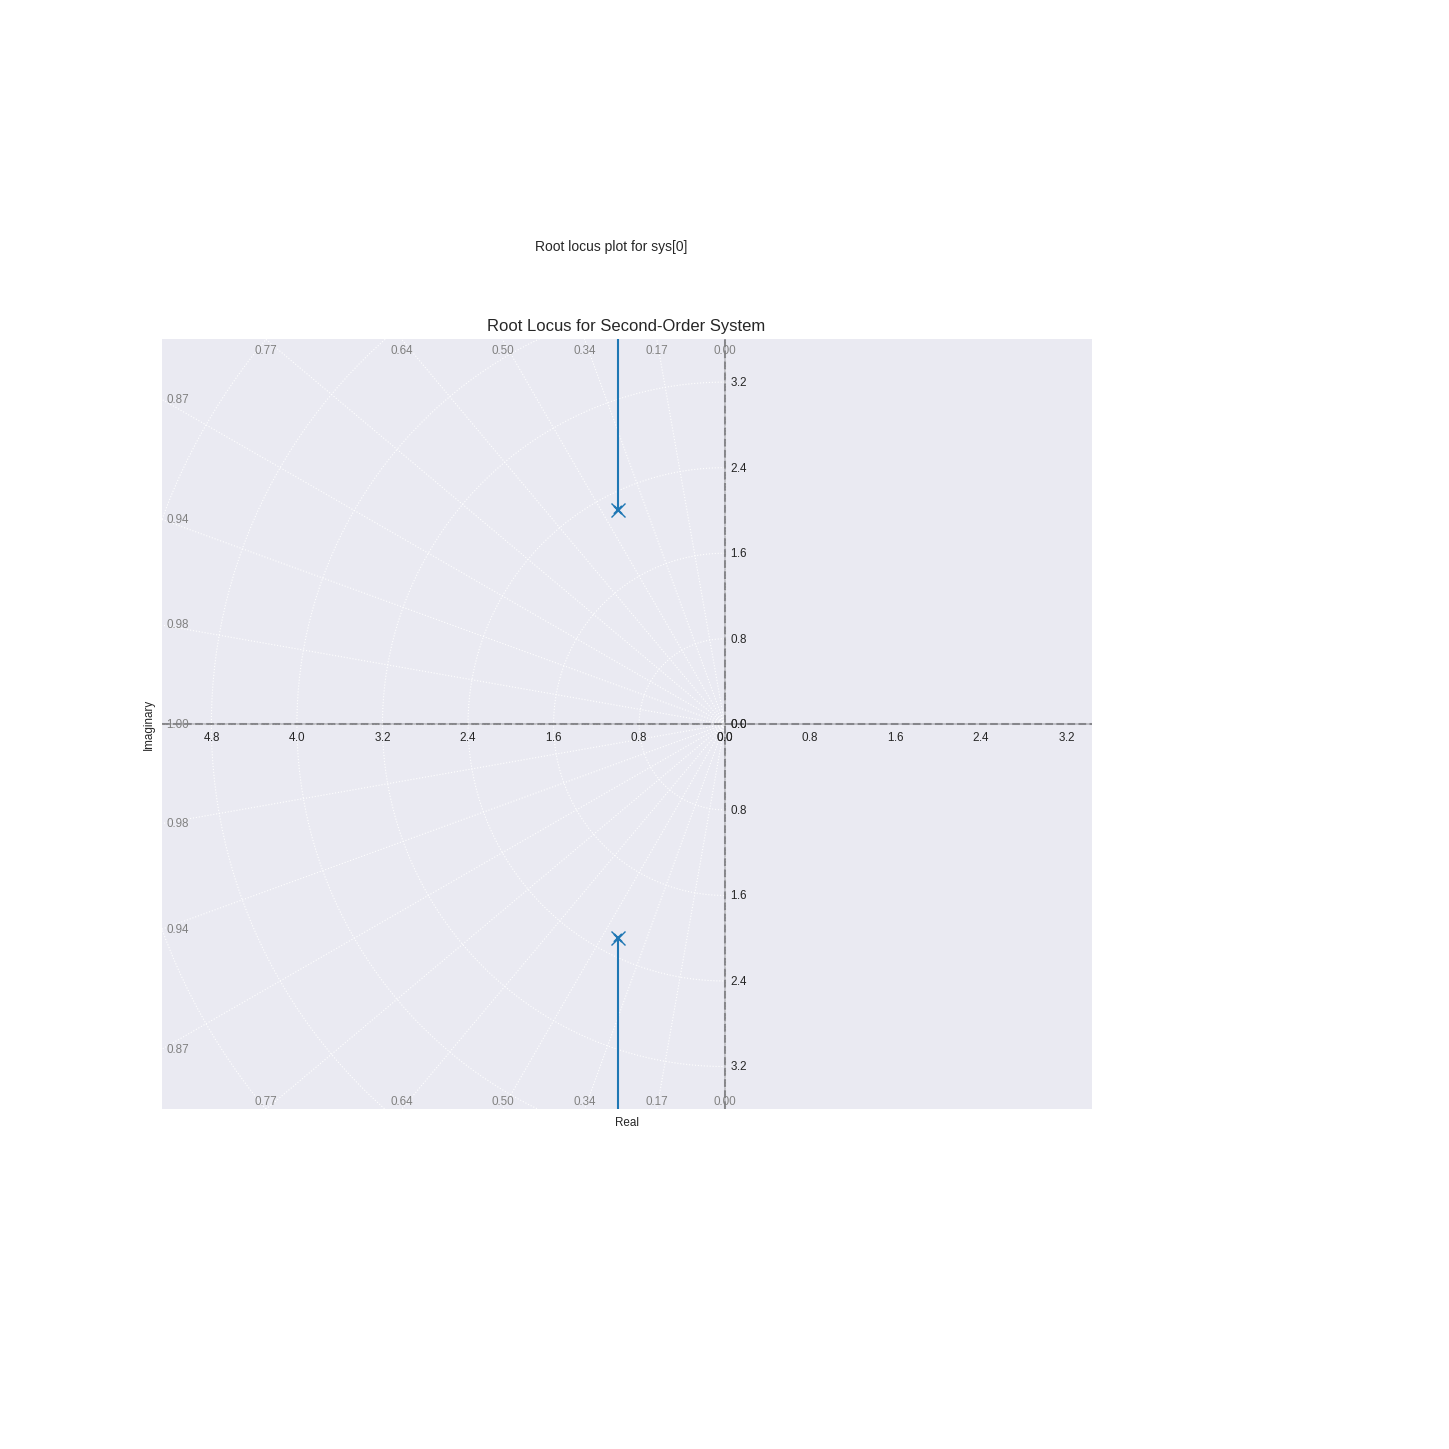

In [6]:
# Create root locus plot
plt.figure(figsize=(12, 10))

# Plot the root locus
rlist, klist = control.root_locus(sys_control, plot=True)

# Mark the open-loop poles with 'x'
plt.plot(np.real(signal.tf2zpk(num, den)[1]), np.imag(signal.tf2zpk(num, den)[1]), 'x', markersize=10)

# Add grid and labels
plt.grid(True)
plt.title('Root Locus for Second-Order System')
plt.xlabel('Real')
plt.ylabel('Imaginary')

# Add the real axis and imaginary axis
plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)

plt.show()

Now let's examine how the closed-loop response changes with different gain values:

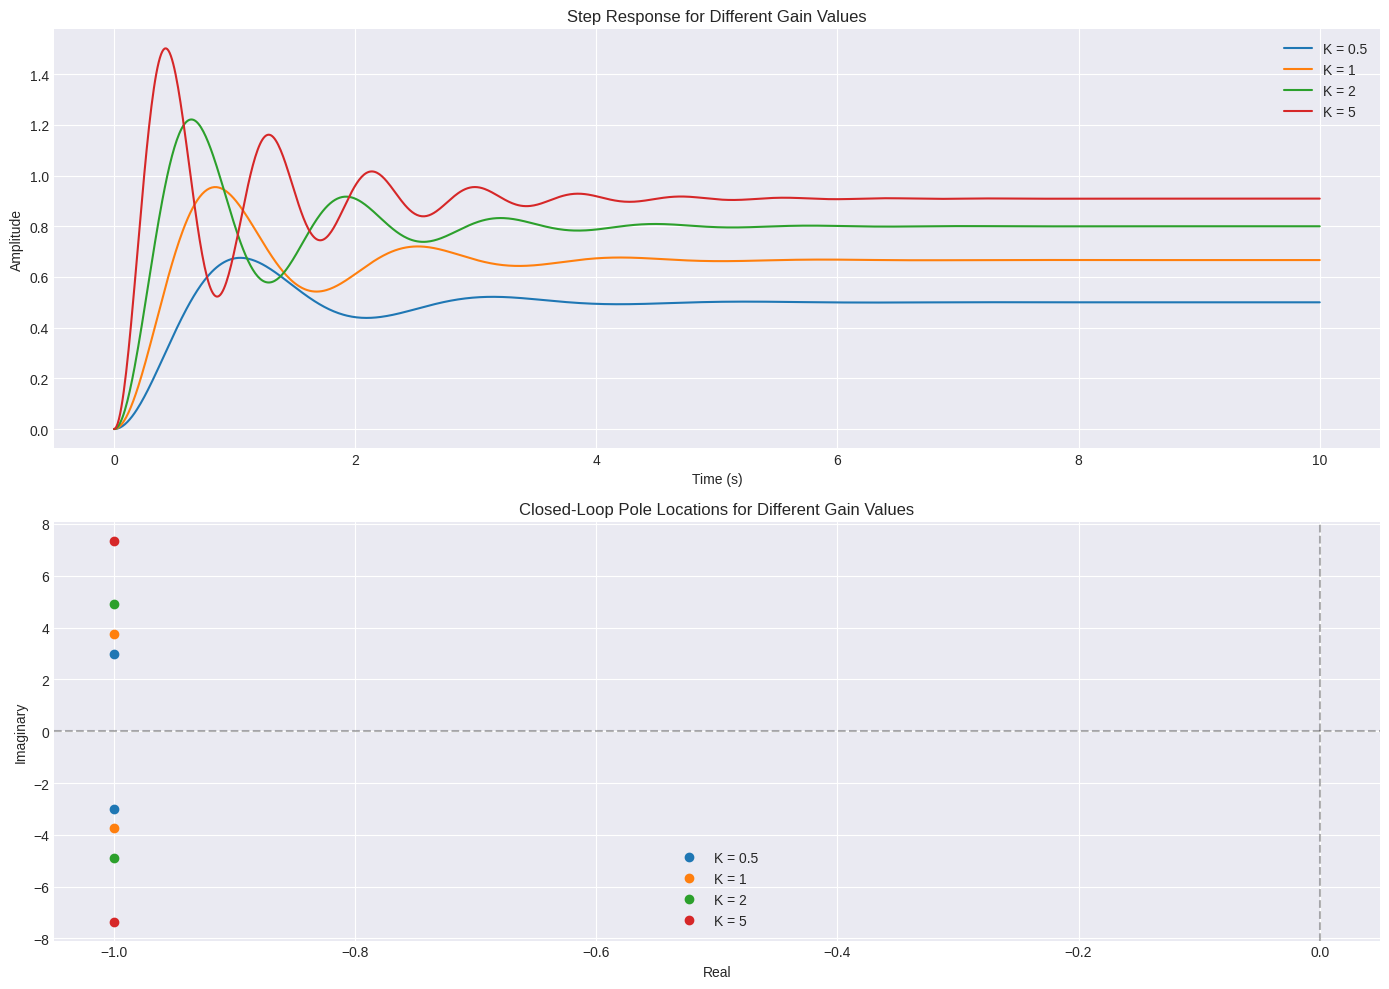

In [7]:
# Evaluate closed-loop response for different gain values
K_values = [0.5, 1, 2, 5]
t = np.linspace(0, 10, 1000)

plt.figure(figsize=(14, 10))

# Plot step responses
plt.subplot(2, 1, 1)
for K in K_values:
    # Create closed-loop system
    cl_sys = control.feedback(K * sys_control, 1)
    
    # Calculate step response
    t_out, y_out = control.step_response(cl_sys, t)
    
    plt.plot(t_out, y_out, label=f'K = {K}')

plt.grid(True)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Step Response for Different Gain Values')
plt.legend()

# Plot pole locations for different gains
plt.subplot(2, 1, 2)

for K in K_values:
    # Create closed-loop system
    cl_sys = control.feedback(K * sys_control, 1)
    
    # Get closed-loop poles
    cl_poles = cl_sys.poles()
    
    # Plot poles
    plt.plot(np.real(cl_poles), np.imag(cl_poles), 'o', label=f'K = {K}')

# Add grid and boundary
plt.grid(True)
plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.title('Closed-Loop Pole Locations for Different Gain Values')
plt.legend()

plt.tight_layout()
plt.show()

**Explanation of Root Locus Results**:

1. **Root locus plot** shows how the closed-loop poles move as the gain K increases.

2. **Stability**: The system is stable when all poles are in the left half of the complex plane (negative real parts).

3. **Dominant poles**: The poles closest to the imaginary axis have the most influence on the transient response.

4. **Effect of gain**:
   - As gain increases, poles move along the root locus
   - Low gain: Slower response, less oscillatory
   - High gain: Faster response, more oscillatory
   - Too high gain: System may become unstable

5. **Design applications**:
   - Select gain to achieve desired damping ratio and natural frequency
   - Balance between speed of response and stability margin

<a id="frequency"></a>
### Frequency Response

Frequency response analysis examines how a system responds to sinusoidal inputs of varying frequencies. This is visualized using Bode and Nyquist plots, which display magnitude and phase information.

Let's create Bode and Nyquist plots for our system:

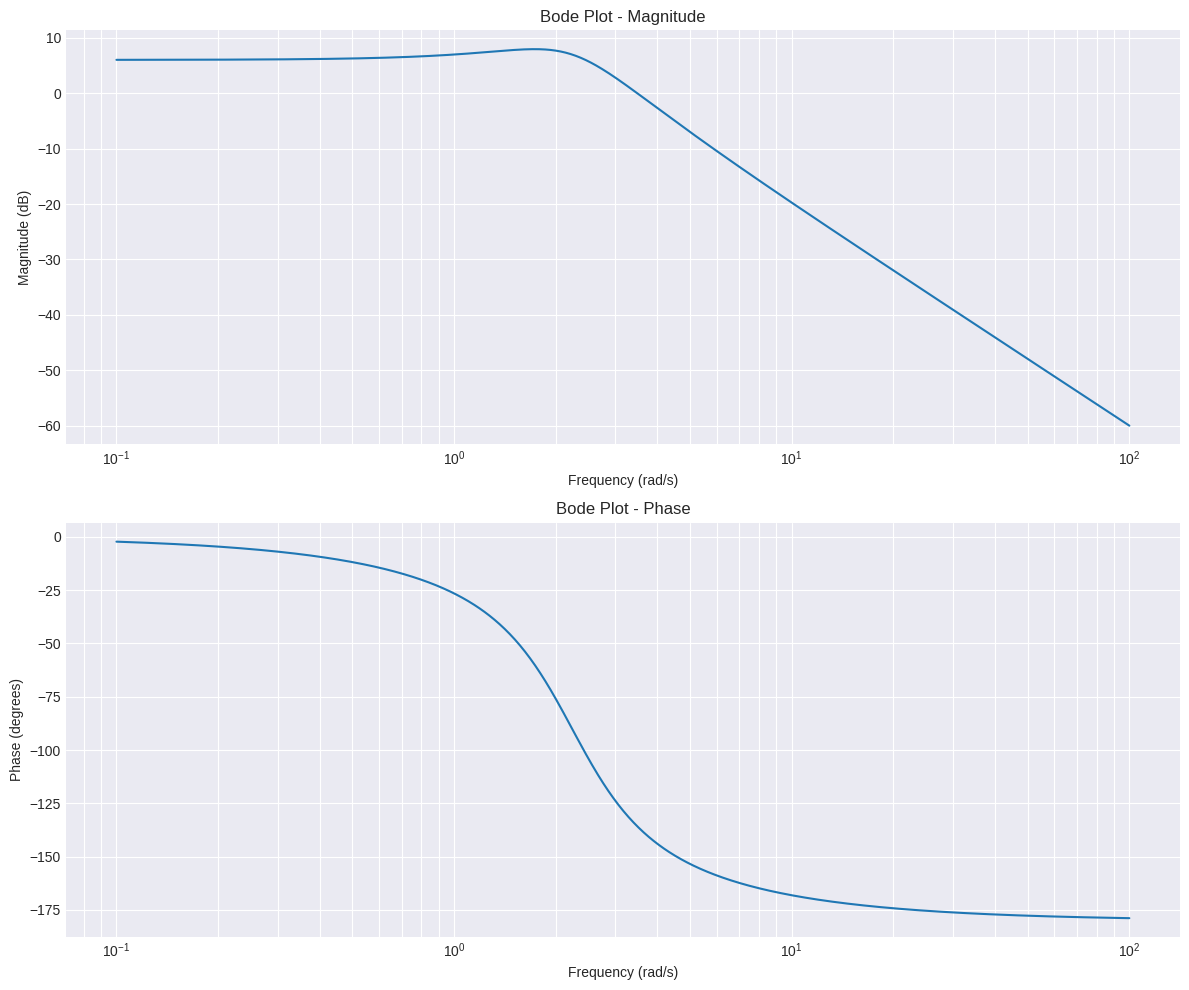

In [8]:
# Define frequency range for analysis
w = np.logspace(-1, 2, 1000)  # 0.1 rad/s to 100 rad/s (logarithmic scale)

# Calculate frequency response using scipy.signal
w_out, mag, phase = signal.bode(sys_scipy, w)

# Plot Bode diagram
plt.figure(figsize=(12, 10))

# Magnitude plot (in dB)
plt.subplot(2, 1, 1)
plt.semilogx(w_out, mag)
plt.grid(True, which="both")
plt.xlabel('Frequency (rad/s)')
plt.ylabel('Magnitude (dB)')
plt.title('Bode Plot - Magnitude')

# Phase plot (in degrees)
plt.subplot(2, 1, 2)
plt.semilogx(w_out, phase)
plt.grid(True, which="both")
plt.xlabel('Frequency (rad/s)')
plt.ylabel('Phase (degrees)')
plt.title('Bode Plot - Phase')

plt.tight_layout()
plt.show()

/home/casierrav/.pyenv/versions/3.12.7/envs/test/lib/python3.12/site-packages/control/freqplot.py:435: FutureWarning: bode_plot() return value of mag, phase, omega is deprecated; use frequency_response()
  warnings.warn(


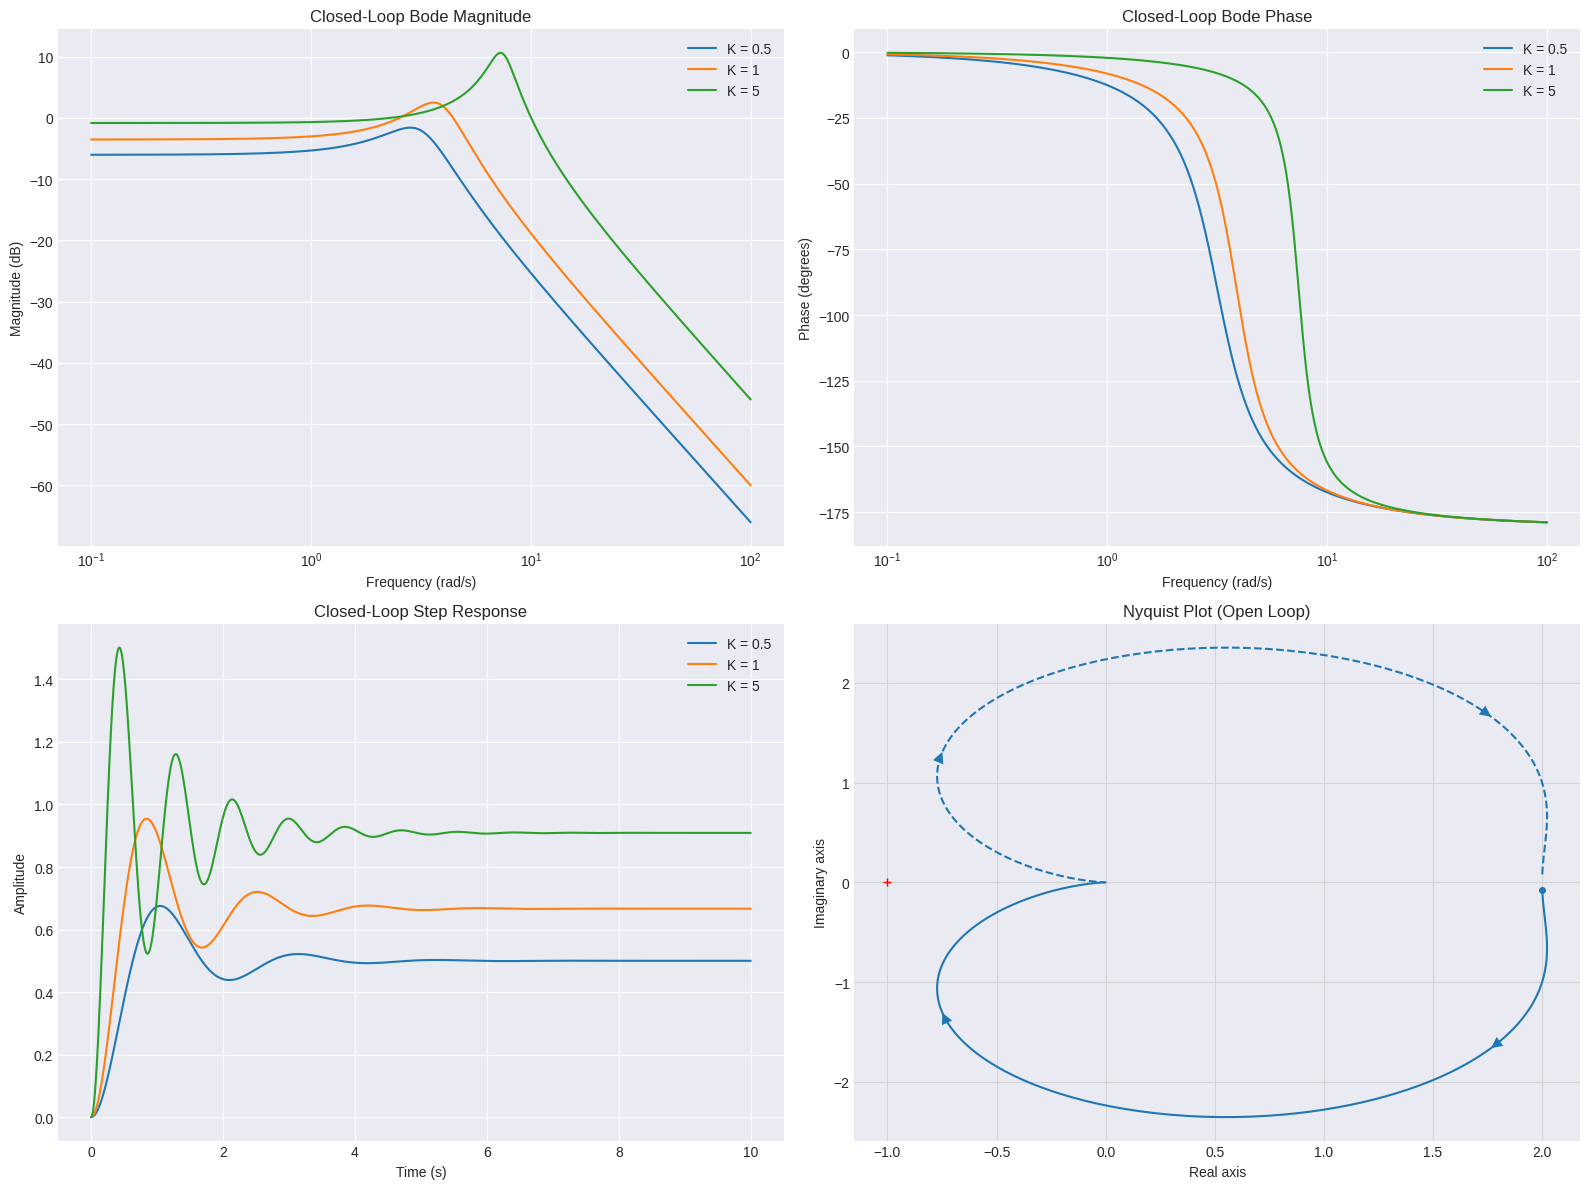

In [9]:
# Analyze different gain factors
K_values = [0.5, 1, 5]

# Create figure with 2 rows, 2 columns
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# Plot Bode magnitude and phase for different gains
for K in K_values:
    # Create closed-loop system
    cl_sys = control.feedback(K * sys_control, 1)
    
    # Calculate and plot magnitude response
    mag, phase, omega = control.bode_plot(cl_sys, omega=w, plot=False)
    axs[0, 0].semilogx(omega, 20*np.log10(mag), label=f'K = {K}')
    axs[0, 1].semilogx(omega, phase * 180/np.pi, label=f'K = {K}')
    
    # Calculate and plot step response
    t_sim = np.linspace(0, 10, 1000)
    t, y = control.step_response(cl_sys, t_sim)
    axs[1, 0].plot(t, y, label=f'K = {K}')

# Create Nyquist plot
control.nyquist_plot(sys_control, omega=w, ax=axs[1, 1])
axs[1, 1].set_title('Nyquist Plot (Open Loop)')

# Label and format plots
axs[0, 0].set_title('Closed-Loop Bode Magnitude')
axs[0, 0].set_xlabel('Frequency (rad/s)')
axs[0, 0].set_ylabel('Magnitude (dB)')
axs[0, 0].grid(True)
axs[0, 0].legend()

axs[0, 1].set_title('Closed-Loop Bode Phase')
axs[0, 1].set_xlabel('Frequency (rad/s)')
axs[0, 1].set_ylabel('Phase (degrees)')
axs[0, 1].grid(True)
axs[0, 1].legend()

axs[1, 0].set_title('Closed-Loop Step Response')
axs[1, 0].set_xlabel('Time (s)')
axs[1, 0].set_ylabel('Amplitude')
axs[1, 0].grid(True)
axs[1, 0].legend()

plt.tight_layout()
plt.show()

**Explanation of Frequency Response Results**:

1. **Bode plot** provides frequency domain analysis of a system by showing:
   - **Magnitude response**: How the system amplifies or attenuates signals at different frequencies
   - **Phase response**: How the system shifts the phase of signals at different frequencies

2. **Key metrics from Bode plots**:
   - **Bandwidth**: Range of frequencies where the system responds effectively
   - **Resonant peak**: Maximum amplification (indicates damping)
   - **Roll-off rate**: How quickly magnitude decreases at high frequencies
   - **Phase margin**: Related to stability and damping ratio

3. **Nyquist plot** provides stability information:
   - It maps the frequency response in the complex plane
   - Stability is determined by encirclements of the -1 point
   - Distance from -1 point relates to gain and phase margins

4. **Design applications**:
   - Filter design
   - Stability analysis
   - Performance specification
   - Loop shaping

### Summary of Classical Control Techniques

We've explored three fundamental techniques in classical control theory:

1. **PID Control**:
   - Practical and widely used in industry
   - Combines proportional, integral, and derivative actions
   - Easy to implement but requires tuning

2. **Root Locus Analysis**:
   - Graphical technique for analyzing stability
   - Shows how poles migrate as gain changes
   - Helps select gain for desired transient response

3. **Frequency Response Analysis**:
   - Bode plots show magnitude and phase across frequencies
   - Nyquist plots provide stability information
   - Useful for filter design and stability analysis

These techniques form the foundation of control theory and are essential for understanding more advanced topics like modern control, adaptive control, and nonlinear control.

<a id="modern"></a>
## Modern Control Theory

Modern control theory uses state-space models and advanced design techniques for multi-variable and high-order systems. Here we explore state feedback, optimal control, observer design, and robust control.

<a id="state-feedback"></a>
### State Feedback Control

State feedback control uses the full state vector to compute the control input. For a linear system:

$$\dot{x} = Ax + Bu$$

The control law is:

$$u = -Kx$$

where $K$ is the state feedback gain matrix, designed (e.g., by pole placement) to achieve desired closed-loop dynamics.

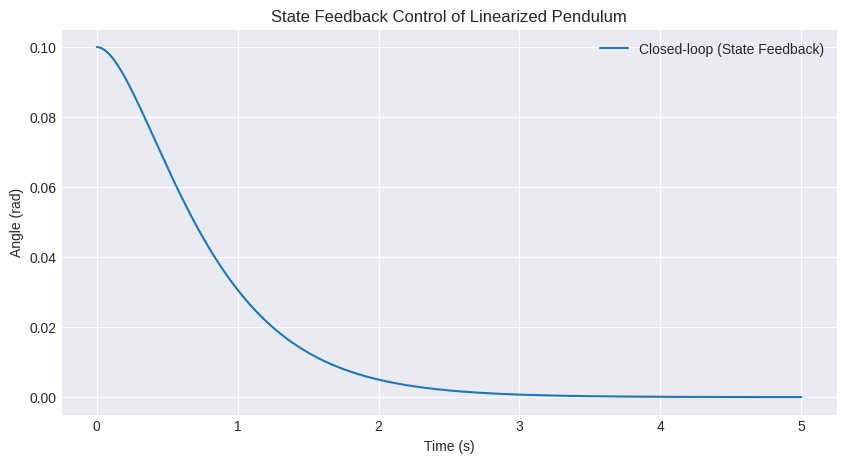

In [10]:
# State Feedback Control Example: Linearized Inverted Pendulum
import numpy as np
import matplotlib.pyplot as plt
import control

# System parameters
g = 9.8   # gravity (m/s^2)
L = 1.0   # pendulum length (m)
m = 1.0   # mass (kg)

A = np.array([[0, 1],
              [g/L, 0]])
B = np.array([[0],
              [1/(m*L**2)]])
C = np.array([[1, 0]])
D = np.array([[0]])

# State feedback gain via pole placement
desired_poles = [-2, -3]
K = control.place(A, B, desired_poles)
A_cl = A - B @ K
sys_cl = control.StateSpace(A_cl, B, C, D)

# Simulate response
t = np.linspace(0, 5, 500)
x0 = [0.1, 0]  # initial state: small angle
t_cl, y_cl = control.initial_response(sys_cl, t, x0)

plt.figure(figsize=(10,5))
plt.plot(t_cl, y_cl, label='Closed-loop (State Feedback)')
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.title('State Feedback Control of Linearized Pendulum')
plt.grid(True)
plt.legend()
plt.show()

**Explanation of State Feedback Results:**

- The closed-loop response shows that the state feedback controller can place the poles at desired locations, resulting in a stable and fast response.
- By adjusting the pole locations, you can control the speed and damping of the system.
- State feedback requires full state measurement, which is not always practical in real systems.

<a id="optimal"></a>
### Optimal Control (LQR)

The Linear Quadratic Regulator (LQR) computes the optimal state feedback gain $K$ to minimize the cost:

$$J = \int_0^\infty (x^T Q x + u^T R u) dt$$

where $Q$ and $R$ are weighting matrices for state and control effort.

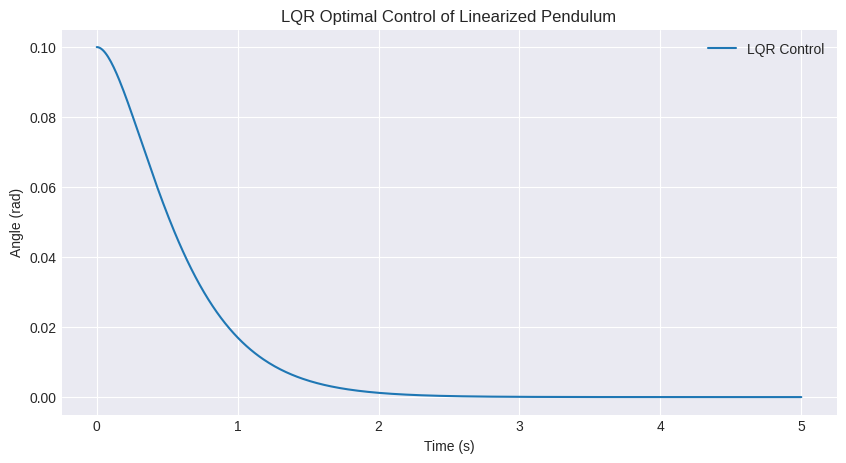

In [11]:
# LQR Optimal Control Example
Q = np.diag([1, 0.1])  # State cost
R = np.array([[0.1]])  # Control cost

K_lqr, S, E = control.lqr(A, B, Q, R)
A_lqr = A - B @ K_lqr
sys_lqr = control.StateSpace(A_lqr, B, C, D)
t_lqr, y_lqr = control.initial_response(sys_lqr, t, x0)

plt.figure(figsize=(10,5))
plt.plot(t_lqr, y_lqr, label='LQR Control')
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.title('LQR Optimal Control of Linearized Pendulum')
plt.grid(True)
plt.legend()
plt.show()

**Explanation of LQR Results:**

- The LQR controller optimally balances state error and control effort according to the weighting matrices $Q$ and $R$.
- The resulting response is stable and typically less aggressive than arbitrary pole placement, with reduced control energy.
- LQR is widely used for its systematic design and robustness to parameter changes.

<a id="observer"></a>
### Observer Design

When not all states are measured, a state observer (e.g., Luenberger observer) estimates the state vector:

$$\dot{\hat{x}} = A\hat{x} + Bu + L(y - C\hat{x})$$

where $L$ is the observer gain, designed to place the estimator poles.

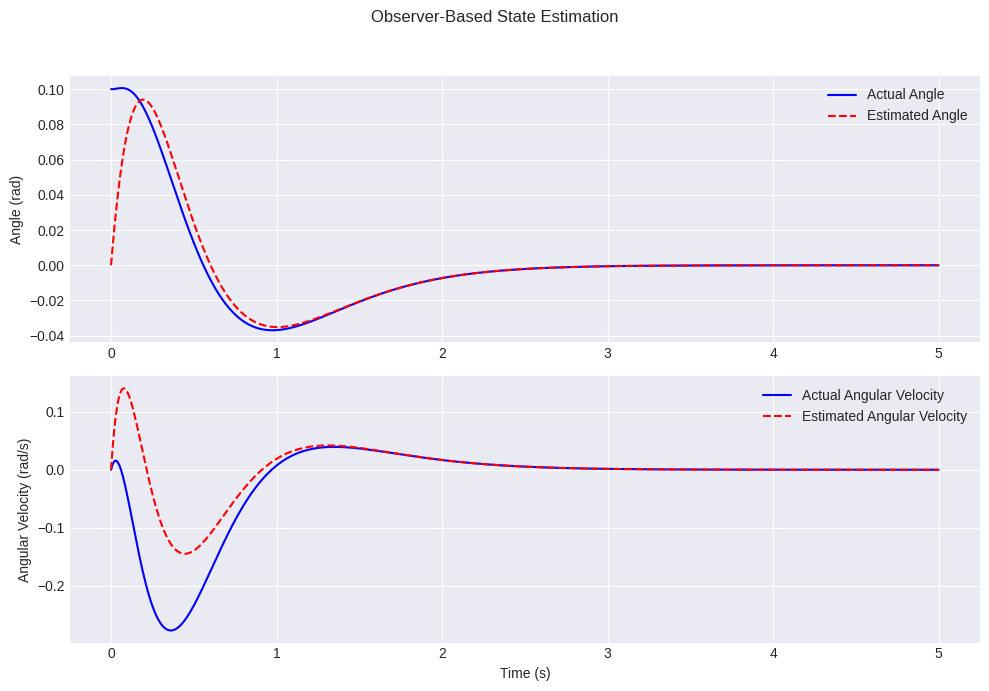

In [12]:
# Observer (Luenberger) Design Example
desired_obs_poles = [-5, -6]
L = control.place(A.T, C.T, desired_obs_poles).T

def simulate_with_observer(t, x0, x0_hat):
    n = len(t)
    x = np.zeros((n, 2))
    x_hat = np.zeros((n, 2))
    u = np.zeros(n)
    y = np.zeros(n)
    x[0] = x0
    x_hat[0] = x0_hat
    y[0] = (C @ x[0])[0]
    dt = t[1] - t[0]
    for i in range(1, n):
        u[i-1] = (-K_lqr @ x_hat[i-1]).item()
        dx = A @ x[i-1] + (B.flatten() * u[i-1])
        x[i] = x[i-1] + dx * dt
        y[i] = (C @ x[i]).item()
        dx_hat = A @ x_hat[i-1] + (B.flatten() * u[i-1]) + L @ (y[i-1] - C @ x_hat[i-1])
        x_hat[i] = x_hat[i-1] + dx_hat * dt
    return x, x_hat, u, y

x0_hat = [0.0, 0.0]
x, x_hat, u, y = simulate_with_observer(t, x0, x0_hat)

plt.figure(figsize=(10,7))
plt.subplot(2,1,1)
plt.plot(t, x[:,0], 'b-', label='Actual Angle')
plt.plot(t, x_hat[:,0], 'r--', label='Estimated Angle')
plt.ylabel('Angle (rad)')
plt.legend()
plt.grid(True)
plt.subplot(2,1,2)
plt.plot(t, x[:,1], 'b-', label='Actual Angular Velocity')
plt.plot(t, x_hat[:,1], 'r--', label='Estimated Angular Velocity')
plt.xlabel('Time (s)')
plt.ylabel('Angular Velocity (rad/s)')
plt.legend()
plt.grid(True)
plt.suptitle('Observer-Based State Estimation')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

**Explanation of Observer Results:**

- The observer (Luenberger) estimates the system states based on output measurements and the system model.
- The estimated states (dashed lines) converge rapidly to the actual states (solid lines), even if the initial estimate is poor.
- Observer design is essential when not all states are directly measurable.

<a id="robust"></a>
### Robust Control

Robust control aims to maintain performance despite model uncertainties. Here, we test the LQR controller under parameter variations (e.g., pendulum length).

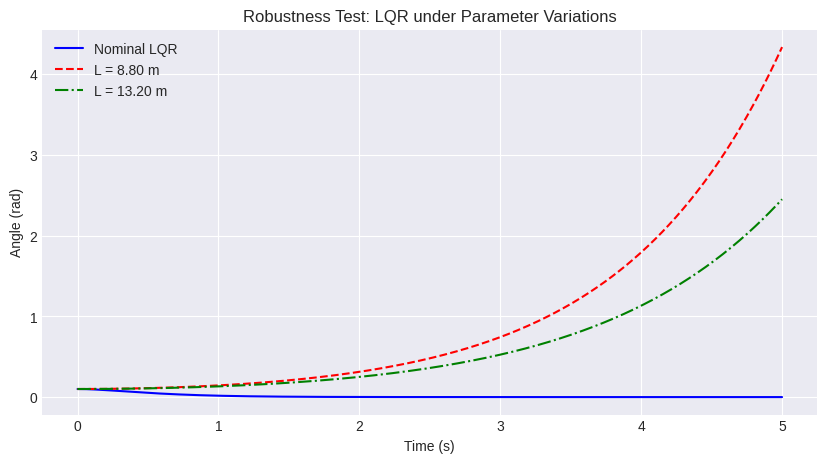

In [13]:
# Robustness Test: LQR under Parameter Variations
L_var = [0.8 * L, 1.2 * L]  # 20% shorter/longer
colors = ['r--', 'g-.']
plt.figure(figsize=(10,5))
plt.plot(t, y_lqr, 'b-', label='Nominal LQR')
for idx, Lp in enumerate(L_var):
    if isinstance(Lp, np.ndarray):
        Lp = Lp.item() if Lp.size == 1 else float(Lp.item(0))
    else:
        Lp = float(Lp)
    A_var = np.array([[0, 1], [g/Lp, 0]])
    B_var = np.array([[0], [1/(m*Lp**2)]])
    sys_var = control.StateSpace(A_var - B_var @ K_lqr, B_var, C, D)
    _, y_var = control.initial_response(sys_var, t, x0)
    plt.plot(t, y_var, colors[idx], label=f'L = {Lp:.2f} m')
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.title('Robustness Test: LQR under Parameter Variations')
plt.legend()
plt.grid(True)
plt.show()

**Explanation of Robust Control Results:**

- The robustness test shows how the LQR controller performs when the pendulum length varies by ±20%.
- The nominal response (blue) is compared to responses with shorter and longer pendulums (dashed lines).
- The controller maintains stability and acceptable performance, demonstrating robustness to parameter uncertainty.

### Summary of Modern Control Techniques

In this section, we explored several advanced control strategies:

1. **State Feedback Control:** Enables precise pole placement for desired dynamics, but requires full state measurement.
2. **Optimal Control (LQR):** Provides a systematic way to balance performance and control effort, resulting in robust and efficient controllers.
3. **Observer Design:** Allows estimation of unmeasured states, enabling implementation of state feedback in practical systems.
4. **Robust Control:** Tests controller performance under model uncertainties, ensuring stability and acceptable behavior even with parameter variations.

These modern techniques are foundational for advanced applications in robotics, aerospace, automotive systems, and more.

<a id="adaptive"></a>
## Adaptive Control

Adaptive control methods adjust controller parameters in real time to cope with changes in system dynamics or the environment. Here we explore Model Reference Adaptive Control (MRAC), Self-Tuning Regulators (STR), and Gain Scheduling.

<a id="mrac"></a>
### Model Reference Adaptive Control (MRAC)

MRAC uses a reference model to specify desired closed-loop behavior. The controller parameters are adjusted online so that the plant output tracks the reference model output, even if the plant parameters are uncertain.

Let's implement a simple MRAC for a first-order system.

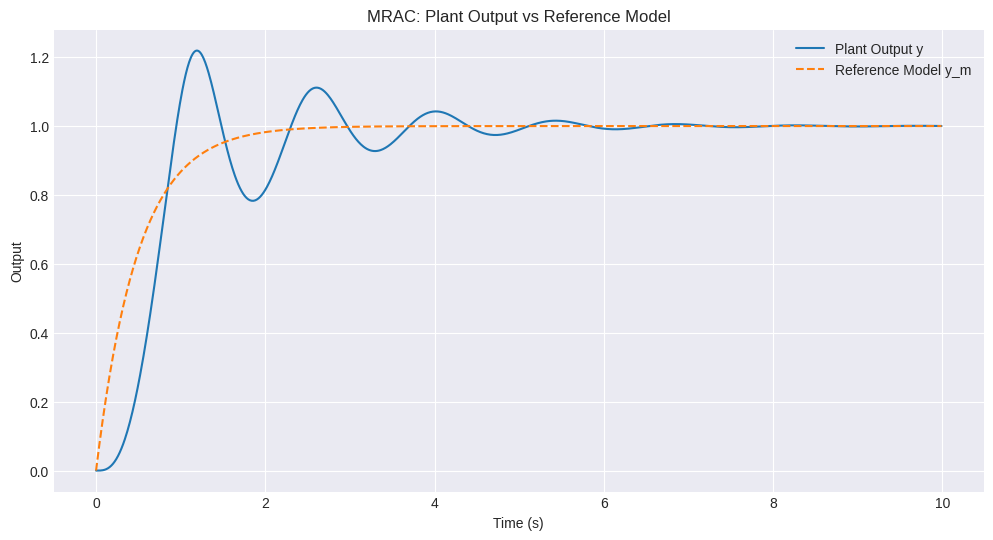

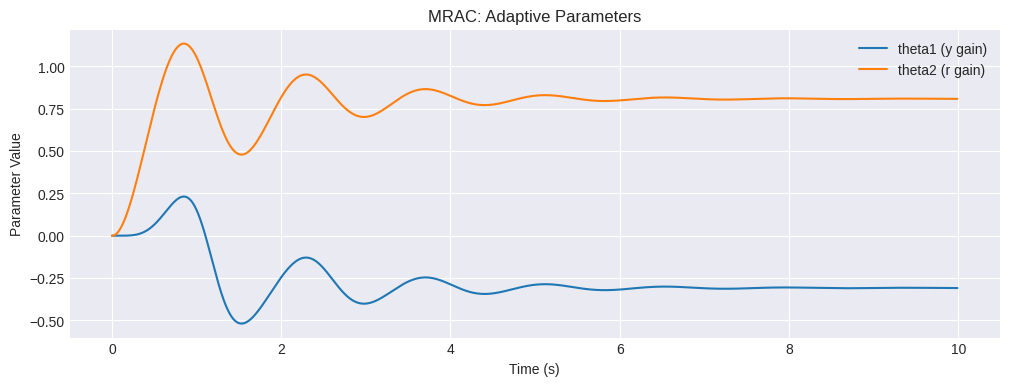

In [14]:
# MRAC Example: First-order system
import numpy as np
import matplotlib.pyplot as plt

# Plant: dy/dt = -a*y + b*u
a_true = 1.0
b_true = 2.0

# Reference model: dy_m/dt = -a_m*y_m + b_m*r
a_m = 2.0
b_m = 2.0

# Adaptive gains
gamma1 = 5.0
gamma2 = 5.0

# Simulation parameters
dt = 0.01
T = 10
t = np.arange(0, T, dt)
n = len(t)

# Initialization
y = np.zeros(n)
y_m = np.zeros(n)
theta1 = 0.0  # Adaptive parameter for y
theta2 = 0.0  # Adaptive parameter for r
theta1_hist = np.zeros(n)
theta2_hist = np.zeros(n)

r = np.ones(n)  # Step reference

for i in range(n-1):
    # Reference model
    y_m[i+1] = y_m[i] + dt*(-a_m*y_m[i] + b_m*r[i])

    # Control law: u = theta1*y + theta2*r
    u = theta1*y[i] + theta2*r[i]

    # Plant
    y[i+1] = y[i] + dt*(-a_true*y[i] + b_true*u)

    # Adaptation law (MIT rule)
    e = y[i] - y_m[i]
    theta1 = theta1 - gamma1 * e * y[i] * dt
    theta2 = theta2 - gamma2 * e * r[i] * dt

    theta1_hist[i+1] = theta1
    theta2_hist[i+1] = theta2

# Plot results
plt.figure(figsize=(12,6))
plt.plot(t, y, label='Plant Output y')
plt.plot(t, y_m, '--', label='Reference Model y_m')
plt.xlabel('Time (s)')
plt.ylabel('Output')
plt.title('MRAC: Plant Output vs Reference Model')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12,4))
plt.plot(t, theta1_hist, label='theta1 (y gain)')
plt.plot(t, theta2_hist, label='theta2 (r gain)')
plt.xlabel('Time (s)')
plt.ylabel('Parameter Value')
plt.title('MRAC: Adaptive Parameters')
plt.legend()
plt.grid(True)
plt.show()

**Explanation of MRAC Results:**

- The plant output (blue) tracks the reference model (dashed) despite initial parameter uncertainty.
- The adaptive parameters (theta1, theta2) adjust in real time to minimize the tracking error.
- MRAC is effective for systems with slowly varying or uncertain parameters.

<a id="str"></a>
### Self-Tuning Regulators (STR)

Self-Tuning Regulators estimate the plant parameters online (using recursive least squares or similar) and update the controller accordingly. This approach is widely used in industrial process control.

Let's implement a simple STR for a first-order system.

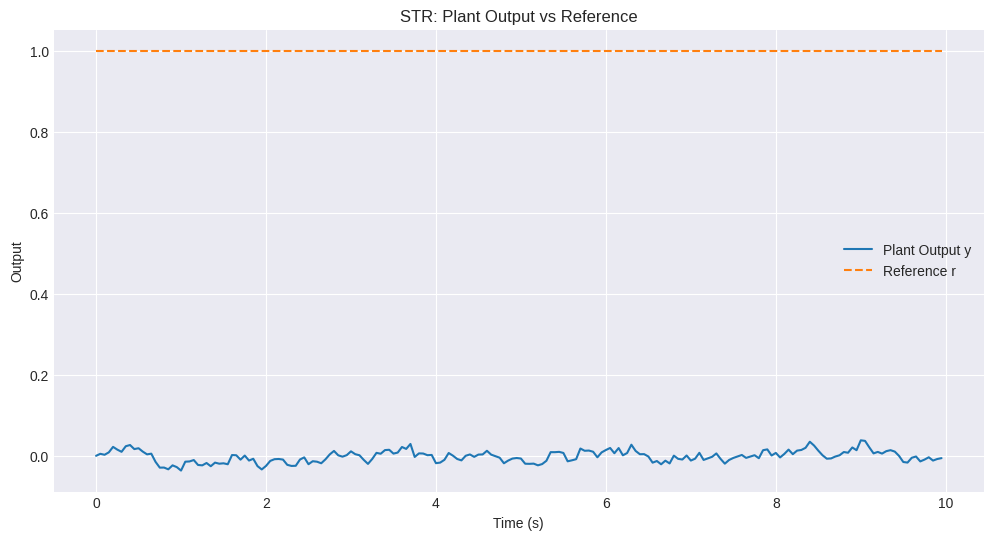

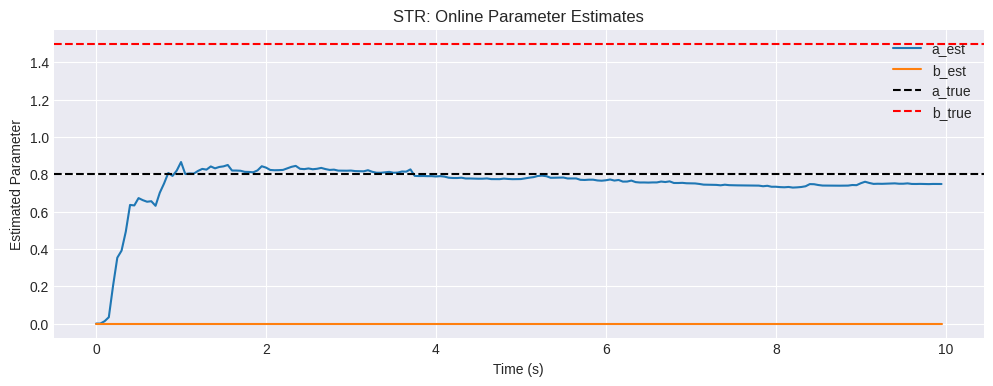

In [15]:
# STR Example: First-order system with Recursive Least Squares (RLS)
np.random.seed(42)
a_true = 0.8
b_true = 1.5
dt = 0.05
T = 10
t = np.arange(0, T, dt)
n = len(t)

y = np.zeros(n)
u = np.zeros(n)
r = np.ones(n)

# RLS initialization
theta = np.array([0.0, 0.0])  # [a_est, b_est]
P = np.eye(2) * 1000
theta_hist = np.zeros((n,2))

# Controller: pole placement for y[k+1] = a*y[k] + b*u[k]
desired_pole = 0.2

for k in range(n-1):
    # Estimate output (simulate plant)
    y[k+1] = a_true * y[k] + b_true * u[k] + 0.01*np.random.randn()

    # RLS update
    phi = np.array([y[k], u[k]])
    y_pred = theta @ phi
    error = y[k+1] - y_pred
    K_rls = P @ phi / (1 + phi @ P @ phi)
    theta = theta + K_rls * error
    P = P - np.outer(K_rls, phi) @ P
    theta_hist[k+1] = theta

    # Controller update (if b_est is not too small)
    a_est, b_est = theta
    if abs(b_est) > 1e-3:
        # u[k] = (r[k+1] - a_est*y[k]) / b_est
        u[k+1] = (desired_pole * r[k+1] - a_est * y[k]) / b_est
    else:
        u[k+1] = 0.0

# Plot results
plt.figure(figsize=(12,6))
plt.plot(t, y, label='Plant Output y')
plt.plot(t, r, '--', label='Reference r')
plt.xlabel('Time (s)')
plt.ylabel('Output')
plt.title('STR: Plant Output vs Reference')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12,4))
plt.plot(t, theta_hist[:,0], label='a_est')
plt.plot(t, theta_hist[:,1], label='b_est')
plt.axhline(a_true, color='k', linestyle='--', label='a_true')
plt.axhline(b_true, color='r', linestyle='--', label='b_true')
plt.xlabel('Time (s)')
plt.ylabel('Estimated Parameter')
plt.title('STR: Online Parameter Estimates')
plt.legend()
plt.grid(True)
plt.show()

**Explanation of STR Results:**

- The STR estimates the plant parameters (a, b) online using RLS.
- The controller adapts to these estimates, keeping the output close to the reference.
- The parameter estimates converge to the true values, demonstrating the self-tuning capability.

<a id="gain"></a>
### Gain Scheduling

Gain scheduling is used for nonlinear or time-varying systems. The controller parameters are adjusted based on a measurable scheduling variable (e.g., speed, temperature).

Let's implement a simple gain scheduling controller for a system whose dynamics change with time.

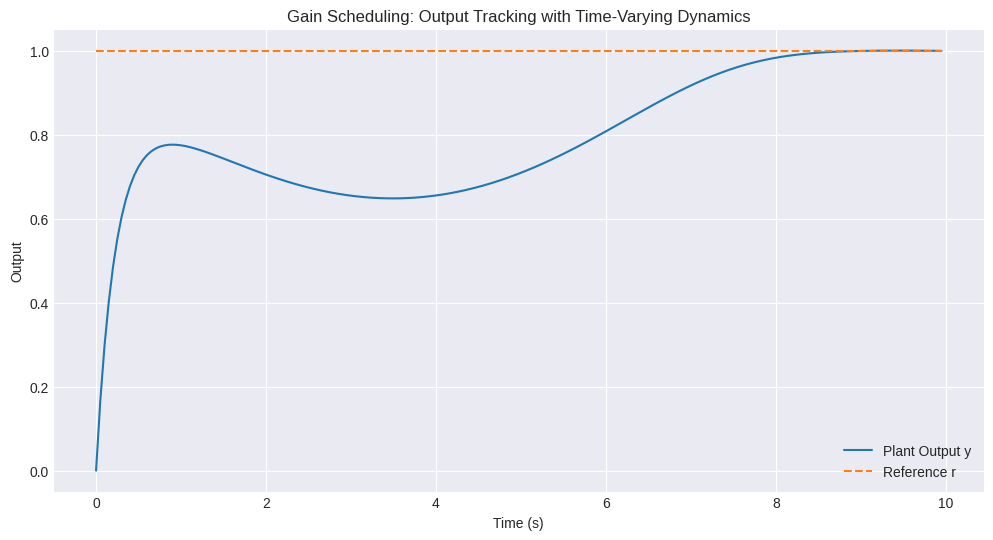

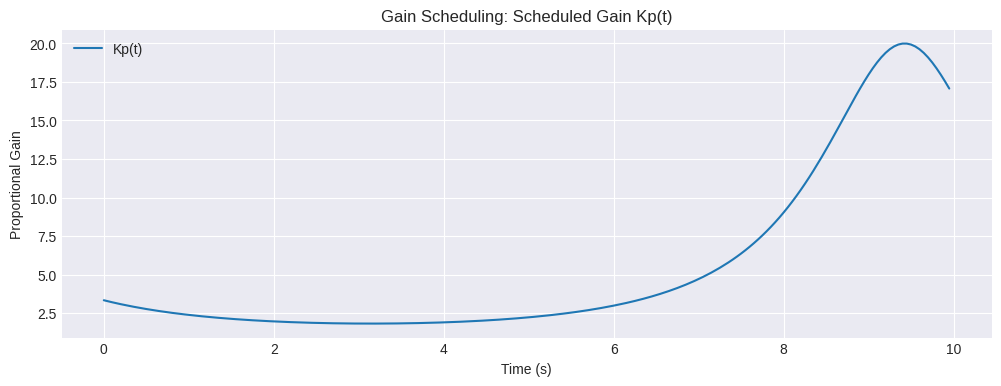

In [16]:
# Gain Scheduling Example: Time-varying first-order system
dt = 0.05
T = 10
t = np.arange(0, T, dt)
n = len(t)

y = np.zeros(n)
u = np.zeros(n)
r = np.ones(n)

# System: dy/dt = -a(t)*y + b*u
def a_time(t):
    return 0.5 + 0.5*np.sin(0.5*t)  # Varies between 0 and 1

# Gain schedule: proportional gain inversely proportional to a(t)
def Kp_schedule(t):
    return 2.0 / (a_time(t) + 0.1)

for k in range(n-1):
    # Controller: u = Kp(t) * (r - y)
    Kp = Kp_schedule(t[k])
    u[k] = Kp * (r[k] - y[k])

    # Plant update (Euler integration)
    y[k+1] = y[k] + dt * (-a_time(t[k]) * y[k] + u[k])

# Plot results
plt.figure(figsize=(12,6))
plt.plot(t, y, label='Plant Output y')
plt.plot(t, r, '--', label='Reference r')
plt.xlabel('Time (s)')
plt.ylabel('Output')
plt.title('Gain Scheduling: Output Tracking with Time-Varying Dynamics')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12,4))
plt.plot(t, [Kp_schedule(ti) for ti in t], label='Kp(t)')
plt.xlabel('Time (s)')
plt.ylabel('Proportional Gain')
plt.title('Gain Scheduling: Scheduled Gain Kp(t)')
plt.legend()
plt.grid(True)
plt.show()

**Explanation of Gain Scheduling Results:**

- The controller gain Kp(t) adapts to the changing system parameter a(t).
- The plant output tracks the reference signal even as the system dynamics vary.
- Gain scheduling is practical for systems with known, measurable variations.

### Summary of Adaptive Control Techniques

In this section, we explored three adaptive control strategies:

1. **Model Reference Adaptive Control (MRAC):** Adjusts controller parameters in real time to force the plant to follow a reference model, effective for uncertain or slowly varying systems.
2. **Self-Tuning Regulators (STR):** Estimates plant parameters online and updates the controller, widely used in industrial applications.
3. **Gain Scheduling:** Adjusts controller gains based on a measurable scheduling variable, suitable for systems with known, measurable variations.

Adaptive control methods are essential for handling systems with uncertainties, nonlinearities, or time-varying dynamics, providing robustness and improved performance.

<a id="nonlinear"></a>
## Nonlinear Control

This section presents four fundamental nonlinear control strategies: Feedback Linearization, Backstepping, Sliding Mode Control, and Passivity-Based Control. Each method is illustrated with a simple example, simulation, and explanation.

<a id="feedback-lin"></a>
### Feedback Linearization

Feedback linearization cancels the nonlinearities in a system by algebraic transformation, making the closed-loop system behave linearly.

**Example:** Consider the nonlinear system $\dot{x} = -x^3 + u$. We want to track a reference $r(t)$.

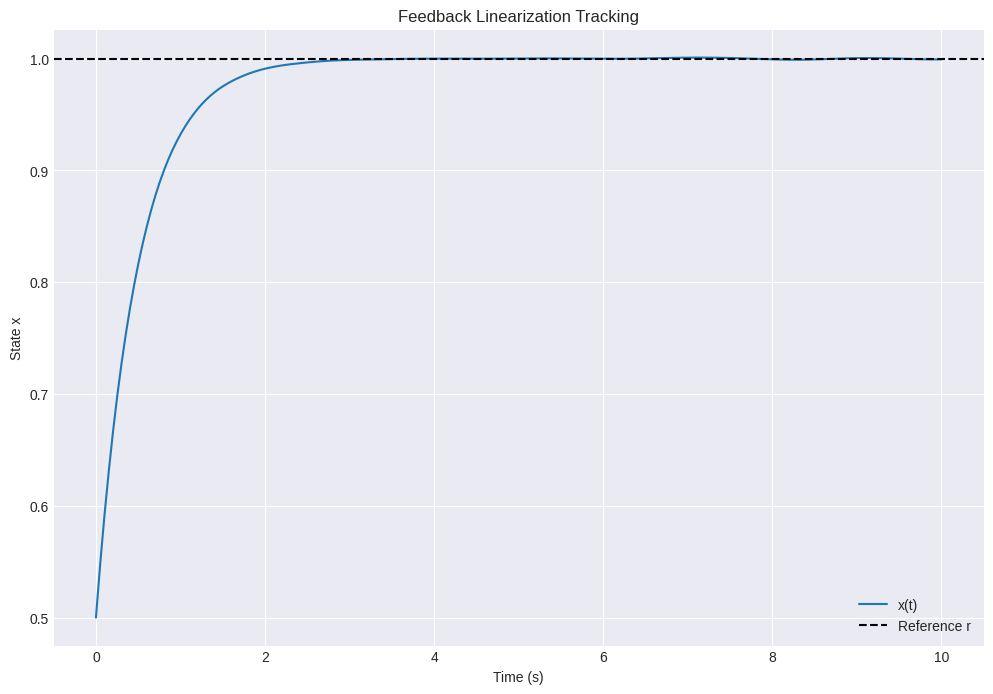

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

def feedback_lin_system(t, x, r=1.0):
    # Feedback linearization control: u = x^3 + v, v = k*(r - x)
    k = 2.0
    v = k * (r - x[0])
    u = x[0]**3 + v
    dxdt = -x[0]**3 + u
    return [dxdt]

sol = solve_ivp(feedback_lin_system, [0, 10], [0.5], t_eval=np.linspace(0, 10, 200))
plt.plot(sol.t, sol.y[0], label='x(t)')
plt.axhline(1.0, color='k', linestyle='--', label='Reference r')
plt.xlabel('Time (s)')
plt.ylabel('State x')
plt.title('Feedback Linearization Tracking')
plt.legend()
plt.grid(True)
plt.show()

**Explanation:**

The nonlinear term $-x^3$ is canceled by the control law. The closed-loop system becomes $\dot{x} = k(r-x)$, a stable linear system. The state $x$ tracks the reference $r$ with exponential convergence.

<a id="backstepping"></a>
### Backstepping

Backstepping is a recursive design method for certain classes of nonlinear systems, especially strict-feedback forms.

**Example:** $\dot{x}_1 = x_2$, $\dot{x}_2 = -x_1 + u$ (track $x_1 \to 0$).

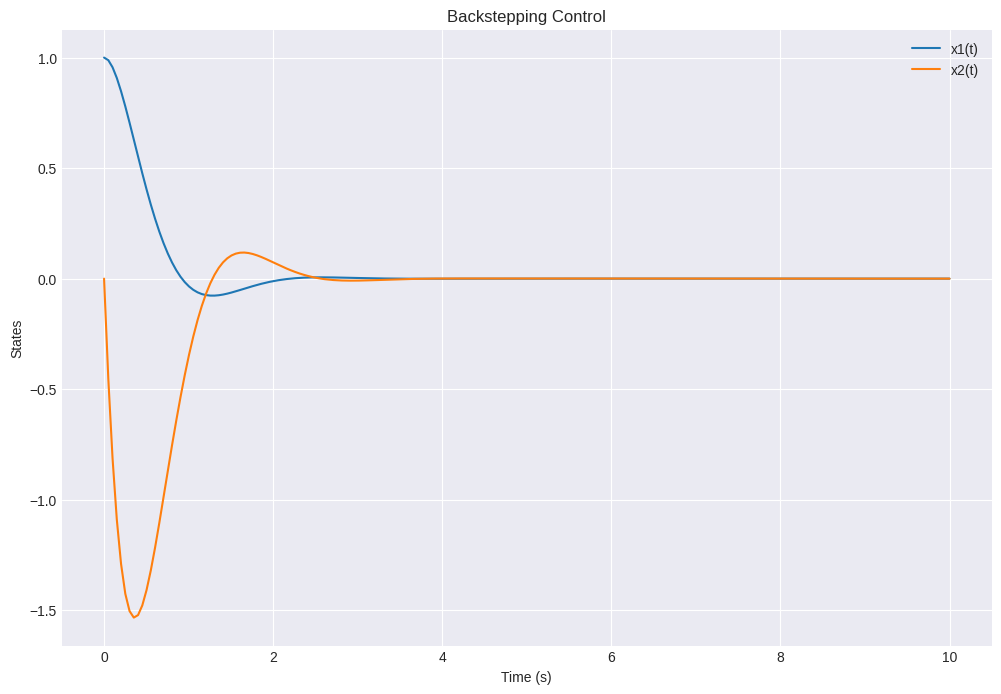

In [18]:
def backstepping_control(t, X):
    x1, x2 = X
    # Virtual control for x2: alpha = -k1*x1
    k1 = 2.0
    alpha = -k1 * x1
    # Backstepping control law
    k2 = 2.0
    u = -x1 - k1*(x2 - alpha) - k2*(x2 - alpha)
    dx1dt = x2
    dx2dt = -x1 + u
    return [dx1dt, dx2dt]

sol = solve_ivp(backstepping_control, [0, 10], [1.0, 0.0], t_eval=np.linspace(0, 10, 200))
plt.plot(sol.t, sol.y[0], label='x1(t)')
plt.plot(sol.t, sol.y[1], label='x2(t)')
plt.xlabel('Time (s)')
plt.ylabel('States')
plt.title('Backstepping Control')
plt.legend()
plt.grid(True)
plt.show()

**Explanation:**

Backstepping stabilizes the system by recursively designing virtual and actual controls. Both $x_1$ and $x_2$ converge to zero, demonstrating global asymptotic stability.

<a id="sliding"></a>
### Sliding Mode Control

Sliding Mode Control (SMC) forces the system state to reach and stay on a predefined sliding surface, providing robustness to disturbances.

**Example:** $\dot{x} = -x + u + d$, with disturbance $d$. Sliding surface: $s = x$.

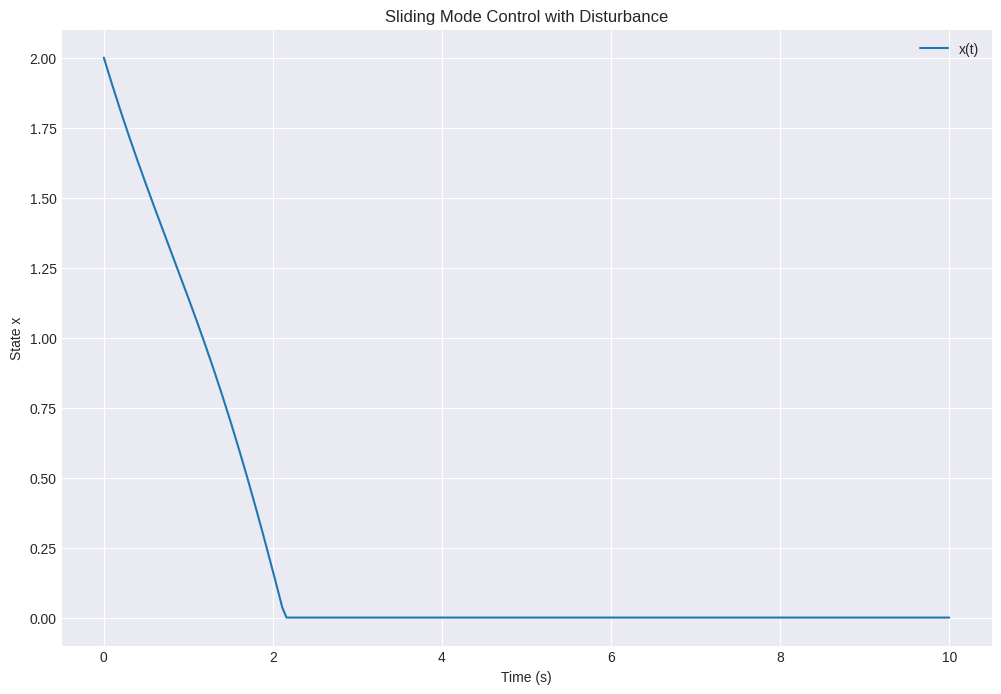

In [19]:
def smc_system(t, x):
    d = 0.2 * np.sin(2*t)  # disturbance
    eta = 1.0
    s = x[0]
    u = -eta * np.sign(s) + x[0]  # SMC law
    dxdt = -x[0] + u + d
    return [dxdt]

sol = solve_ivp(smc_system, [0, 10], [2.0], t_eval=np.linspace(0, 10, 200))
plt.plot(sol.t, sol.y[0], label='x(t)')
plt.xlabel('Time (s)')
plt.ylabel('State x')
plt.title('Sliding Mode Control with Disturbance')
plt.legend()
plt.grid(True)
plt.show()

**Explanation:**

The SMC law drives $x$ to zero despite the disturbance $d$. The system is robust, but the control may exhibit chattering (high-frequency switching).

<a id="passivity"></a>
### Passivity-Based Control

Passivity-based control exploits the system's energy properties to ensure stability.

**Example:** Simple mass-spring-damper: $m\ddot{x} + b\dot{x} + kx = u$.

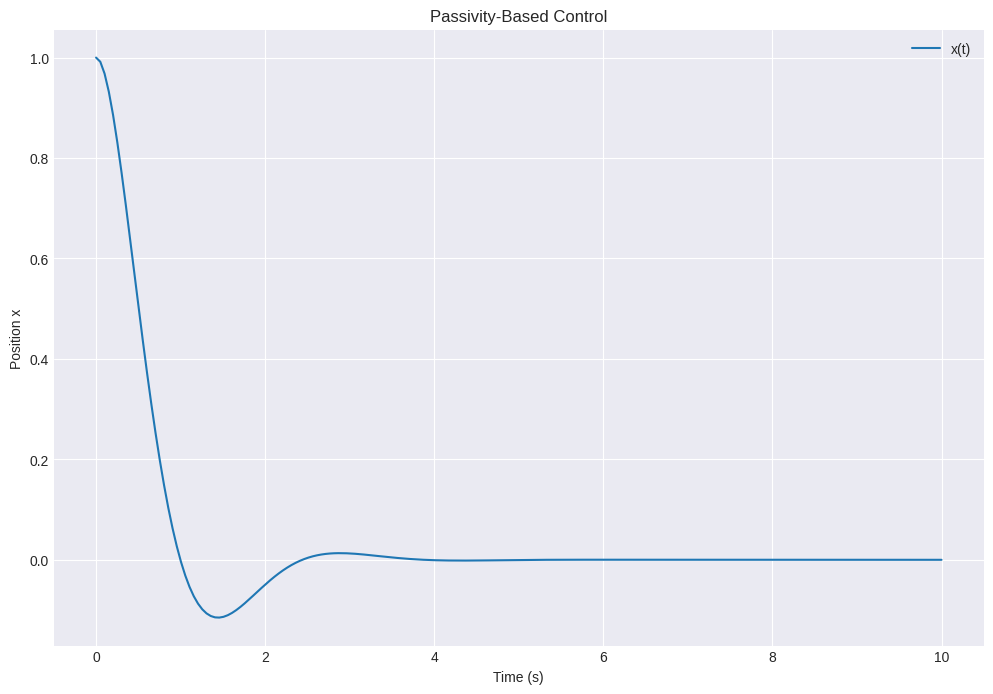

In [20]:
def passivity_system(t, X):
    x, v = X
    m, b, k = 1.0, 0.5, 2.0
    # Passivity-based control: u = -k*x - b*v - k_p*x - k_d*v
    k_p, k_d = 3.0, 2.0
    u = -k*x - b*v - k_p*x - k_d*v
    dxdt = v
    dvdt = (u - b*v - k*x) / m
    return [dxdt, dvdt]

sol = solve_ivp(passivity_system, [0, 10], [1.0, 0.0], t_eval=np.linspace(0, 10, 200))
plt.plot(sol.t, sol.y[0], label='x(t)')
plt.xlabel('Time (s)')
plt.ylabel('Position x')
plt.title('Passivity-Based Control')
plt.legend()
plt.grid(True)
plt.show()

**Explanation:**

The control law injects damping and stiffness, shaping the system's energy to ensure convergence to the origin. The state $x$ decays to zero smoothly.

### Summary of Nonlinear Control Techniques

- **Feedback Linearization:** Cancels nonlinearities, making the system behave linearly. Effective for systems where exact model knowledge is available.
- **Backstepping:** Recursive design for strict-feedback systems, ensuring stability by construction.
- **Sliding Mode Control:** Robust to disturbances and uncertainties, but may cause chattering.
- **Passivity-Based Control:** Uses energy shaping and damping injection for stability, suitable for physical systems with passive properties.

Nonlinear control methods extend classical techniques to a broader class of systems, providing powerful tools for robust and adaptive control in real-world applications.